In [1]:
%load_ext autoreload
%autoreload 2

import numpy as np
import scipy as sp
import pandas as pd
from os import listdir
from os.path import isfile, join
import pymc3 as pm
import math as m
import arviz as az

import dive
import matplotlib.pyplot as plt
import deerlab as dl

from theano import tensor as T
from theano.tensor import nlinalg as tnp
from theano.tensor import slinalg as snp

### Generate a synthetic distribution and calculate S

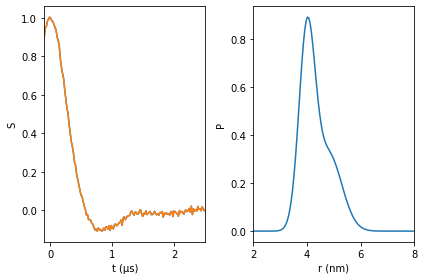

In [56]:
testdata, testpars = dive.generateMultiGauss(nr = 120, nt = 150, seed = 129)

t = testdata['t']
S = testdata['S']
Ptruth = testdata['P']
r = testdata['r']
S0 = testdata['S0']

Vscale = 1
S = Vscale*S
S0 = Vscale*S

sigma_model = testpars['sigma']


fig, ax = plt.subplots(1,2)
line0 = ax[0].plot(t, S0)
line1 = ax[0].plot(t, S)
line2 = ax[1].plot(r, Ptruth)

ax[0].set(xlim = [min(t),max(t)], xlabel = 't (µs)', ylabel = 'S')
ax[1].set(xlim = [min(r),max(r)], xlabel = 'r (nm)', ylabel = 'P')
plt.tight_layout()
plt.show()

### Initialize parameters and matrices

In [44]:
K = dl.dipolarkernel(t,r,integralop=True)    # kernel matrix
K[:,0] = 2*K[:,0]
K[:,-1] = 2*K[:,-1]

In [45]:
KtK = np.matmul(np.transpose(K),K)
KtS = np.matmul(np.transpose(K),S)

L = dl.regoperator(np.linspace(1,len(r),len(r)), 2)
LtL = np.matmul(np.transpose(L),L)

In [46]:
a0 = 0.01
b0 = 1e-6

### Setup model

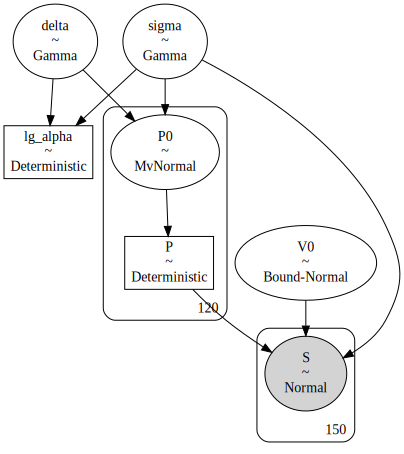

In [52]:
with pm.Model() as model:
    # Noise
    sigma = pm.Gamma('sigma', alpha=0.7, beta=2)
    # tau = pm.Deterministic('tau',1/(sigma**2))
    tau = 1/sigma**2

    # Regularization parameter
    # a = a0 + nr/2
    # b = b0 + (1/2)*T.sum(pm.math.dot(L,P0)**2)
    a = a0
    b = b0
    delta = pm.Gamma('delta', alpha=a, beta=b)
    lg_alpha = pm.Deterministic('lg_alpha',np.log10(np.sqrt(delta/tau)))
    
    # Time Domain
        # Time domain
    V0 = pm.Bound(pm.Normal,lower=0.0)('V0', mu=1, sigma=0.2)

    # Distribution
    invSigma = (tau*KtK+delta*LtL)
    Sigma = tnp.matrix_inverse(invSigma)
    C_L = snp.cholesky(Sigma)

    P0 = pm.MvNormal("P0", mu = testdata['P'], chol = C_L, shape = len(r)) 


    P = pm.Deterministic("P",P0/T.sum(P0)/(r[1]-r[0]))

    Smodel = V0*pm.math.dot(K,P)

    # Likelihood
    pm.Normal('S',mu = Smodel, sigma = sigma, observed = S)

pm.model_to_graphviz(model)

### Run sampler

In [53]:
with model:
    step_P0 = dive.SampleExpandedEdwardsModel(P0, delta, sigma, V0, KtK, KtS, LtL, len(r))  
    trace = pm.sample(step = step_P0, chains=2, cores=2, draws=5000, tune=3000, return_inferencedata=False, progressbar = False)

Multiprocess sampling (2 chains in 2 jobs)
CompoundStep
>SampleExpandedEdwardsModel: [P0]
>NUTS: [V0, delta, sigma]
Sampling 2 chains for 3_000 tune and 5_000 draw iterations (6_000 + 10_000 draws total) took 418 seconds.


### Analysis

mean        sd     hdi_3%    hdi_97%  mcse_mean  mcse_sd  \
V₀         1.005     0.004      0.997      1.012      0.000    0.000   
σ          0.012     0.001      0.010      0.014      0.000    0.000   
δ      34768.821  8948.790  19075.543  51350.677    156.971  111.005   
lg(α)      0.337     0.076      0.197      0.481      0.001    0.001   

       ess_bulk  ess_tail  r_hat  
V₀       5795.0    5342.0    1.0  
σ        3990.0    5613.0    1.0  
δ        3080.0    3648.0    1.0  
lg(α)    2862.0    3910.0    1.0

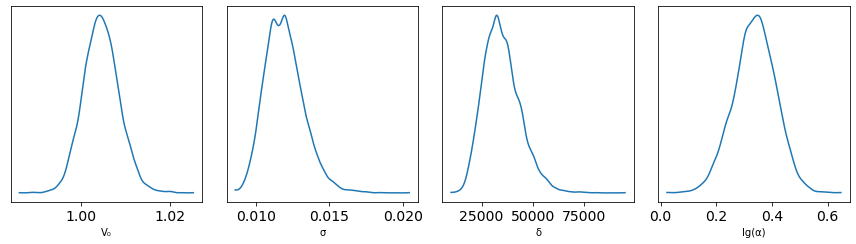

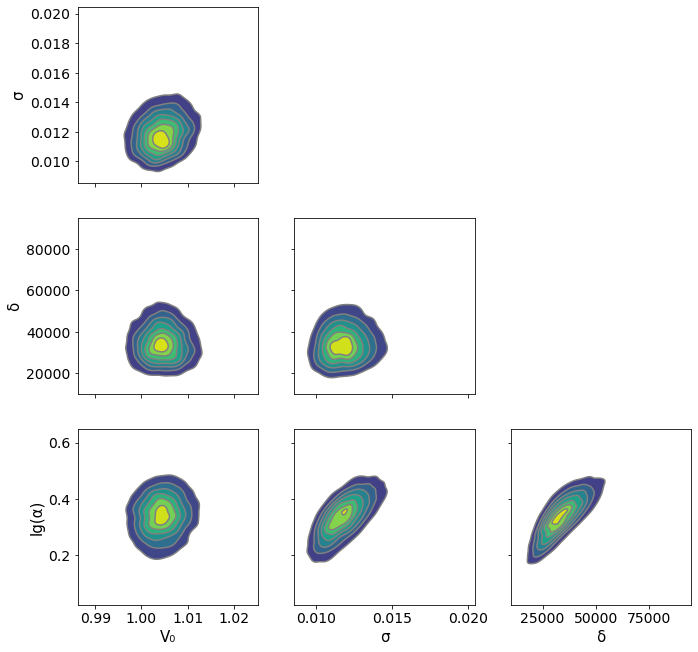

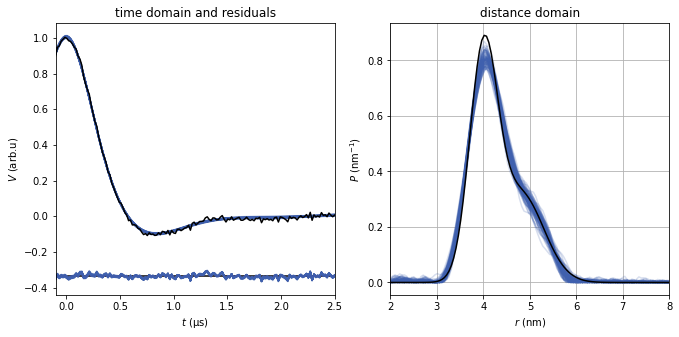

In [57]:
dive.summary(trace, model, S, t, r, Pref = testdata['P'])   

### Now the same with increased noise level

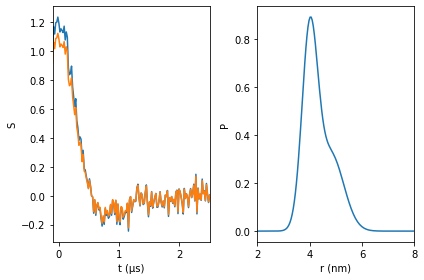

In [37]:
testdata, testpars = dive.generateMultiGauss(nr = 150, nt = 150, sigma = 0.05, seed = 129)

t = testdata['t']
S = testdata['S']
Ptruth = testdata['P']
r = testdata['r']
S0 = testdata['S0']

sigma_model = testpars['sigma']

Vscale = 1.1
S = Vscale*S
S0 = Vscale*S


fig, ax = plt.subplots(1,2)
line0 = ax[0].plot(t, S0)
line1 = ax[0].plot(t, S)
line2 = ax[1].plot(r, Ptruth)

ax[0].set(xlim = [min(t),max(t)], xlabel = 't (µs)', ylabel = 'S')
ax[1].set(xlim = [min(r),max(r)], xlabel = 'r (nm)', ylabel = 'P')
plt.tight_layout()
plt.show()

Snoise = S

In [ ]:
K = dl.dipolarkernel(t,r,integralop=True)    # kernel matrix
K[:,0] = 2*K[:,0]
K[:,-1] = 2*K[:,-1]

In [38]:
KtK = np.matmul(np.transpose(K),K)
KtS = np.matmul(np.transpose(K),S)

L = dl.regoperator(np.linspace(1,len(r),len(r)), 2)
LtL = np.matmul(np.transpose(L),L)

In [ ]:
a0 = 0.01
b0 = 1e-6

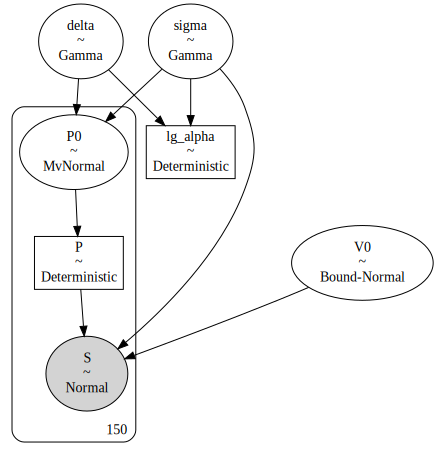

In [39]:
with pm.Model() as model:
    # Noise
    sigma = pm.Gamma('sigma', alpha=0.7, beta=2)
    # tau = pm.Deterministic('tau',1/(sigma**2))
    tau = 1/sigma**2

    # Regularization parameter
    # a = a0 + nr/2
    # b = b0 + (1/2)*T.sum(pm.math.dot(L,P0)**2)
    a = a0
    b = b0
    delta = pm.Gamma('delta', alpha=a, beta=b)
    lg_alpha = pm.Deterministic('lg_alpha',np.log10(np.sqrt(delta/tau)))
    
    # Time Domain
        # Time domain
    V0 = pm.Bound(pm.Normal,lower=0.0)('V0', mu=1, sigma=0.2)

    # Distribution
    invSigma = (tau*KtK+delta*LtL)
    Sigma = tnp.matrix_inverse(invSigma)
    C_L = snp.cholesky(Sigma)

    P0 = pm.MvNormal("P0", mu = testdata['P'], chol = C_L, shape = len(r)) 

    # P = pm.Deterministic("P",P0)
    P = pm.Deterministic("P",P0/T.sum(P0)/(r[1]-r[0]))

    Smodel = V0*pm.math.dot(K,P)

    # Likelihood
    pm.Normal('S',mu = Smodel, sigma = sigma, observed = S)

pm.model_to_graphviz(model)

In [40]:
with model:
    step_P0 = dive.SampleExpandedEdwardsModel(P0, delta, sigma, V0, KtK, KtS, LtL, len(r))  
    noisy_trace = pm.sample(step = step_P0, chains=2, cores=2, draws=5000, tune=3000, return_inferencedata=False, progressbar = False)

Multiprocess sampling (2 chains in 2 jobs)
CompoundStep
>SampleExpandedEdwardsModel: [P0]
>NUTS: [V0, delta, sigma]
Sampling 2 chains for 3_000 tune and 5_000 draw iterations (6_000 + 10_000 draws total) took 726 seconds.
The number of effective samples is smaller than 25% for some parameters.


mean        sd    hdi_3%    hdi_97%  mcse_mean  mcse_sd  ess_bulk  \
V₀         1.113     0.018     1.079      1.147      0.000    0.000    5719.0   
σ          0.056     0.004     0.049      0.064      0.000    0.000    4115.0   
δ      19309.464  5624.228  9358.707  29455.027    167.068  118.165    1082.0   
lg(α)      0.883     0.069     0.747      1.005      0.002    0.001    1220.0   

       ess_tail  r_hat  
V₀       5318.0    1.0  
σ        4943.0    1.0  
δ        1765.0    1.0  
lg(α)    2045.0    1.0

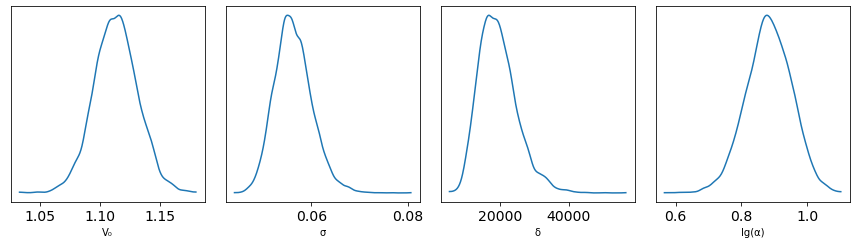

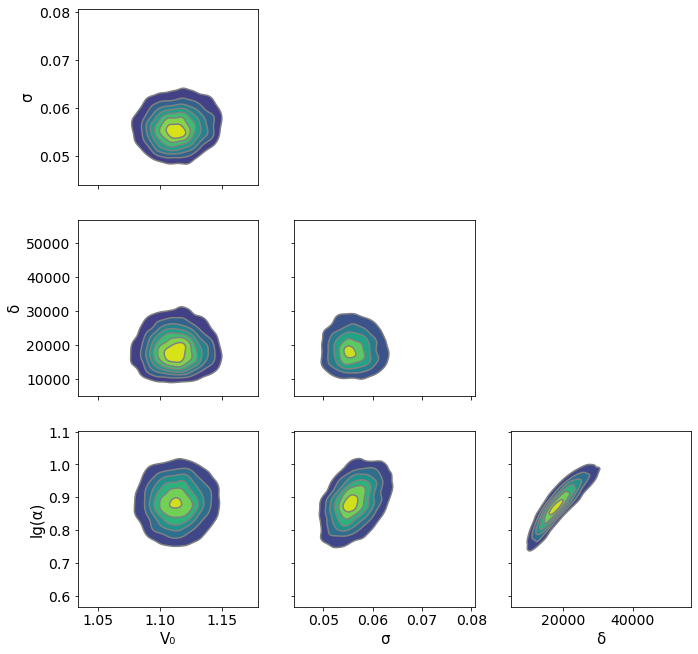

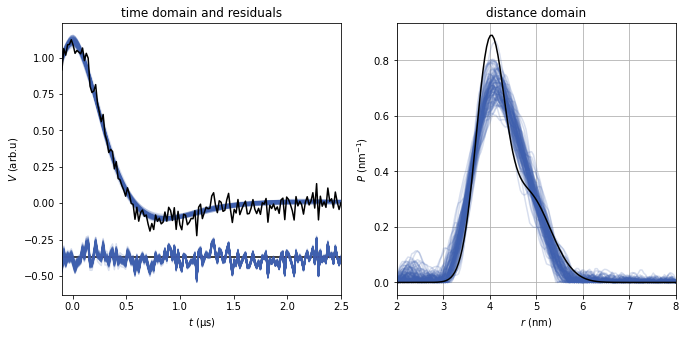

In [42]:
dive.summary(noisy_trace, model, S, t, r, Pref = testdata['P'])

### Get some different V0

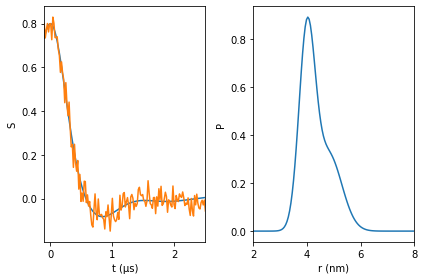

In [2]:
testdata, testpars = dive.generateMultiGauss(nr = 125, nt = 150, sigma = 0.05, seed = 7)

t = testdata['t']
S = testdata['S']
Ptruth = testdata['P']
r = testdata['r']
S0 = testdata['S0']

sigma_model = testpars['sigma']

Vscale = 0.8
S = Vscale*S
S0 = Vscale*S0


fig, ax = plt.subplots(1,2)
line0 = ax[0].plot(t, S0)
line1 = ax[0].plot(t, S)
line2 = ax[1].plot(r, Ptruth)

ax[0].set(xlim = [min(t),max(t)], xlabel = 't (µs)', ylabel = 'S')
ax[1].set(xlim = [min(r),max(r)], xlabel = 'r (nm)', ylabel = 'P')
plt.tight_layout()
plt.show()

Snoise = S

In [3]:
K = dl.dipolarkernel(t,r,integralop=True)    # kernel matrix
K[:,0] = 2*K[:,0]
K[:,-1] = 2*K[:,-1]

KtK = np.matmul(np.transpose(K),K)
KtS = np.matmul(np.transpose(K),S)

L = dl.regoperator(np.linspace(1,len(r),len(r)), 2)
LtL = np.matmul(np.transpose(L),L)

a0 = 0.01
b0 = 1e-6

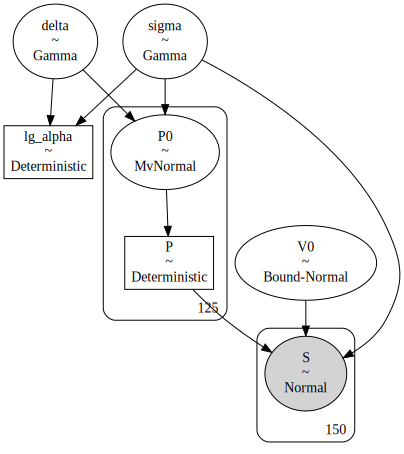

In [4]:
with pm.Model() as model:
    # Noise
    sigma = pm.Gamma('sigma', alpha=0.7, beta=2)
    # tau = pm.Deterministic('tau',1/(sigma**2))
    tau = 1/sigma**2

    # Regularization parameter
    # a = a0 + nr/2
    # b = b0 + (1/2)*T.sum(pm.math.dot(L,P0)**2)
    a = a0
    b = b0
    delta = pm.Gamma('delta', alpha=a, beta=b)
    lg_alpha = pm.Deterministic('lg_alpha',np.log10(np.sqrt(delta/tau)))
    
    # Time Domain
        # Time domain
    V0 = pm.Bound(pm.Normal,lower=0.0)('V0', mu=1, sigma=0.2)

    # Distribution
    invSigma = (tau*KtK+delta*LtL)
    Sigma = tnp.matrix_inverse(invSigma)
    C_L = snp.cholesky(Sigma)

    P0 = pm.MvNormal("P0", mu = testdata['P'], chol = C_L, shape = len(r)) 

    # P = pm.Deterministic("P",P0)
    P = pm.Deterministic("P",P0/T.sum(P0)/(r[1]-r[0]))

    Smodel = V0*pm.math.dot(K,P)

    # Likelihood
    pm.Normal('S',mu = Smodel, sigma = sigma, observed = S)

pm.model_to_graphviz(model)

In [5]:
with model:
    step_P0 = dive.SampleExpandedEdwardsModel(P0, delta, sigma, V0, KtK, KtV, LtL, len(r))  
    noisy_trace = pm.sample(step = step_P0, chains=2, cores=2, draws=5000, tune=3000, return_inferencedata=False, progressbar = False)

Multiprocess sampling (2 chains in 2 jobs)
CompoundStep
>SampleExpandedEdwardsModel: [P0]
>NUTS: [V0, delta, sigma]
Sampling 2 chains for 3_000 tune and 5_000 draw iterations (6_000 + 10_000 draws total) took 539 seconds.
The acceptance probability does not match the target. It is 0.8939879287924679, but should be close to 0.8. Try to increase the number of tuning steps.
The number of effective samples is smaller than 10% for some parameters.


mean        sd    hdi_3%    hdi_97%  mcse_mean  mcse_sd  ess_bulk  \
V₀         0.811     0.012     0.790      0.835      0.000    0.000    4727.0   
σ          0.042     0.003     0.037      0.048      0.000    0.000    4605.0   
δ      10023.578  3263.607  4265.497  15896.273    105.970   74.955     870.0   
lg(α)      0.608     0.078     0.464      0.753      0.002    0.002     993.0   

       ess_tail  r_hat  
V₀       5264.0    1.0  
σ        4939.0    1.0  
δ        1489.0    1.0  
lg(α)    1642.0    1.0

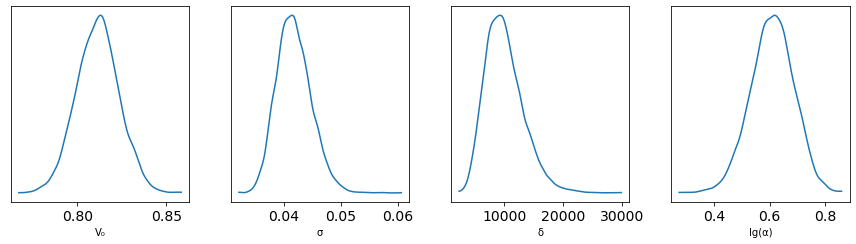

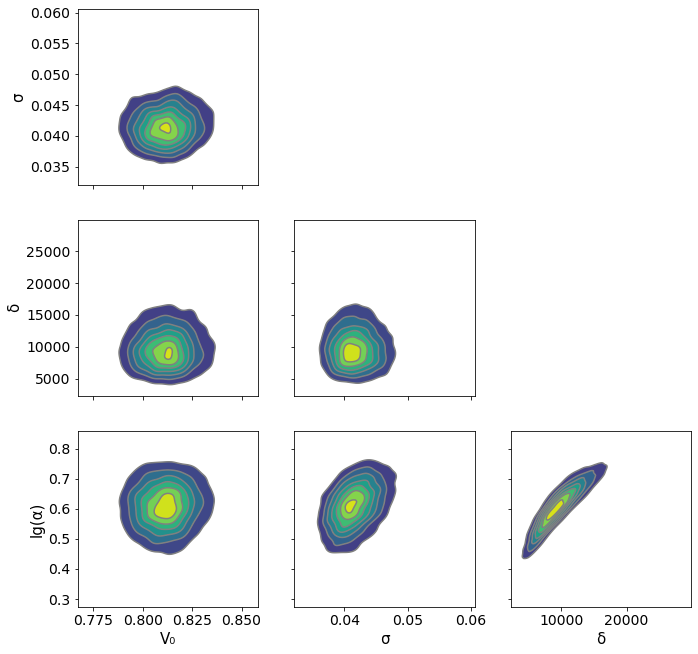

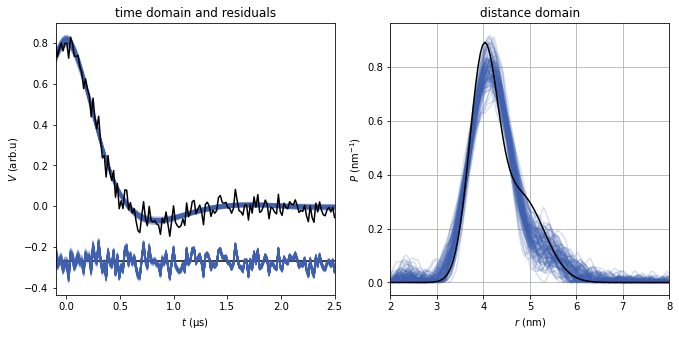

In [6]:
dive.summary(noisy_trace, model, S, t, r, Pref = testdata['P'])